Simple example for dropout as regularization, then Monte-Carlo dropout, with most of the code stolen from
https://xuwd11.github.io/Dropout_Tutorial_in_PyTorch/

# **Convolutional neural network, dropout as regularization**

In [0]:
## import all important libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import time
import h5py
import os
import subprocess
from scipy.ndimage.interpolation import rotate

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

import pymc3 as pm

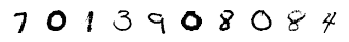

label: [7 0 1 3 9 0 8 0 8 4]
image data shape: (1, 28, 28)


In [0]:
## load MNIST training and test data
transform = transforms.Compose([transforms.ToTensor()])

trainset = datasets.MNIST(root='data/', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='data/', train=False, transform=transform)

# Visualize 10 image samples in MNIST dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
dataiter = iter(trainloader)
images, labels = dataiter.next()
# plot 10 sample images
_,ax = plt.subplots(1,10)
ax = ax.flatten()
iml = images[0].numpy().shape[1]
[ax[i].imshow(np.transpose(images[i].numpy(),(1,2,0)).reshape(iml,-1),cmap='Greys') for i in range(10)]
[ax[i].set_axis_off() for i in range(10)]
plt.show()
print('label:',labels[:10].numpy())
print('image data shape:',images[0].numpy().shape)

In [0]:
## a helper class to flatten tensors
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

## a ConvNet, with  2 convolutional layers, one dense layer, dropout rate configurable
class LeNet(nn.Module):
    def __init__(self, droprate=0.5):
        super(LeNet, self).__init__()
        self.model = nn.Sequential()
        self.model.add_module('conv1', nn.Conv2d(1, 20, kernel_size=5, padding=2))
        self.model.add_module('dropout1', nn.Dropout2d(p=droprate))
        self.model.add_module('maxpool1', nn.MaxPool2d(2, stride=2))
        self.model.add_module('conv2', nn.Conv2d(20, 50, kernel_size=5, padding=2))
        self.model.add_module('dropout2', nn.Dropout2d(p=droprate))
        self.model.add_module('maxpool2', nn.MaxPool2d(2, stride=2))
        self.model.add_module('flatten', Flatten())
        self.model.add_module('dense3', nn.Linear(50*7*7, 500))
        self.model.add_module('relu3', nn.ReLU())
        self.model.add_module('dropout3', nn.Dropout(p=droprate))
        self.model.add_module('final', nn.Linear(500, 10))
        
    def forward(self, x):
        return self.model(x)

In [0]:
## sklearn-like interface, make sure we keep track of all the test results
class LeNetClassifier:
    def __init__(self, droprate=0.5, batch_size=128, max_epoch=300, lr=0.01):
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.lr = lr
        self.model = LeNet(droprate)
        self.model.cuda()
        self.criterion = nn.CrossEntropyLoss().cuda()
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.loss_ = []
        self.test_error = []
        self.test_accuracy = []
        
    def fit(self, trainset, testset, verbose=True):
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=True)
        testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)
        X_test, y_test = iter(testloader).next()
        X_test = X_test.cuda()
        print(self.model)
        for epoch in range(self.max_epoch):
            running_loss = 0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                # inputs, labels = Variable(inputs), Variable(labels)
                inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                # print(loss.data)
                running_loss += loss.data.item()
            self.loss_.append(running_loss / len(trainloader))
            if verbose:
                print('Epoch {} loss: {}'.format(epoch+1, self.loss_[-1]))
            y_test_pred = self.predict(X_test).cpu()
            self.test_accuracy.append(np.mean(y_test.numpy() == y_test_pred.numpy())) 
            self.test_error.append(int(len(testset)*(1-self.test_accuracy[-1])))
            if verbose:
                print('Test error: {}; test accuracy: {}'.format(self.test_error[-1], self.test_accuracy[-1]))
        return self
    
    def predict(self, x):
        model = self.model.eval()
        outputs = model(Variable(x))
        _, pred = torch.max(outputs.data, 1)
        model = self.model.train()
        return pred

In [0]:
## now train! Dont train per default (takes too long)
do_train = True
if do_train:
  # Define networks
  lenet1 = [LeNetClassifier(droprate=0, max_epoch=1500),
            LeNetClassifier(droprate=0.5, max_epoch=1500)]
        
  # Training, set verbose=True to see loss after each epoch.
  [lenet.fit(trainset, testset,verbose=True) for lenet in lenet1]

  # Save torch models
  for ind, lenet in enumerate(lenet1):
    torch.save(lenet.model, 'mnist_lenet1_'+str(ind)+'.pth')
    # Prepare to save errors
    lenet.test_error = list(map(str, lenet.test_error))

  # Save test errors to plot figures
  open("lenet1_test_errors.txt","w").write('\n'.join([','.join(lenet.test_error) for lenet in lenet1]))

LeNet(
  (model): Sequential(
    (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (dropout1): Dropout2d(p=0, inplace=False)
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (dropout2): Dropout2d(p=0, inplace=False)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten()
    (dense3): Linear(in_features=2450, out_features=500, bias=True)
    (relu3): ReLU()
    (dropout3): Dropout(p=0, inplace=False)
    (final): Linear(in_features=500, out_features=10, bias=True)
  )
)
Epoch 1 loss: 1.337701271020019
Test error: 1136; test accuracy: 0.8864
Epoch 2 loss: 0.33601345522190207
Test error: 752; test accuracy: 0.9248
Epoch 3 loss: 0.24899357867075692
Test error: 658; test accuracy: 0.9341


KeyboardInterrupt: ignored

In [0]:
def downloadFiles():
  for i in [ "mnist_lenet1_0.pth", "mnist_lenet1_1.pth", "lenet1_test_errors.txt" ]:
    if not os.path.exists ( i ):
      print ( "downloading %s" % i  )
      out = subprocess.getoutput ( "wget http://www.hephy.at/user/wwaltenberger/%s" % i )
      print ( out )
    else:
      print ( "file %s exists already" % i )

In [0]:
downloadFiles()

downloading mnist_lenet1_0.pth
--2020-02-19 13:38:13--  http://www.hephy.at/user/wwaltenberger/mnist_lenet1_0.pth
Resolving www.hephy.at (www.hephy.at)... 193.170.243.198
Connecting to www.hephy.at (www.hephy.at)|193.170.243.198|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5045206 (4.8M)
Saving to: ‘mnist_lenet1_0.pth’

     0K .......... .......... .......... .......... ..........  1% 1.06M 5s
    50K .......... .......... .......... .......... ..........  2% 2.15M 3s
   100K .......... .......... .......... .......... ..........  3% 44.5M 2s
   150K .......... .......... .......... .......... ..........  4% 62.0M 2s
   200K .......... .......... .......... .......... ..........  5% 2.26M 2s
   250K .......... .......... .......... .......... ..........  6% 89.6M 1s
   300K .......... .......... .......... .......... ..........  7% 93.6M 1s
   350K .......... .......... .......... .......... ..........  8%  130M 1s
   400K .......... .......... .......... .

In [0]:
# Load saved models to CPU
lenet1_models = [torch.load('mnist_lenet1_'+str(ind)+'.pth', map_location={'cuda:0': 'cpu'}) for ind in [0,1]]

# Load saved test errors to plot figures.
lenet1_test_errors = [error_array.split(',') for error_array in 
                      open("lenet1_test_errors.txt","r").read().split('\n')]
lenet1_test_errors = np.array(lenet1_test_errors,dtype='f')

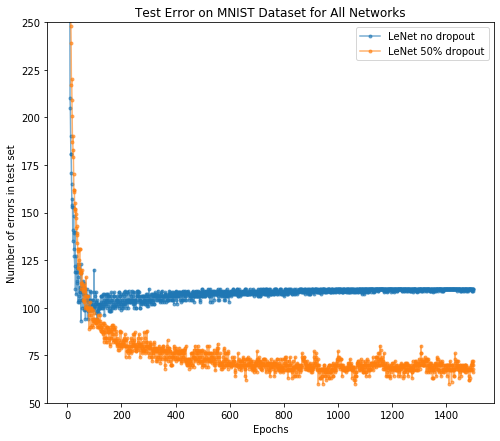

In [0]:
labels = ['LeNet no dropout',
          'LeNet 50% dropout']

plt.figure(figsize=(8, 7))
for i, r in enumerate(lenet1_test_errors.tolist()):
    plt.plot(range(1, len(r)+1), r, '.-', label=labels[i], alpha=0.6);
plt.ylim([50, 250]);
plt.legend(loc=1);
plt.xlabel('Epochs');
plt.ylabel('Number of errors in test set');
plt.title('Test Error on MNIST Dataset for All Networks')
plt.show()

Indeed, 50% dropout layers are a good regularization scheme!

### **Monte Carlo Dropout as Bayesian Approximation**

Now we rotate the digits in a circle, 12 times, so we see the changing variance of the predictions!

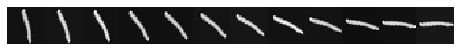

In [0]:
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)
X_test, y_test = iter(testloader).next()
X_test = X_test.numpy()
X1 = np.array([rotate(X_test[9978].squeeze(), i, reshape=False) for i in range(50, 130, 7)])
X1 = X1.reshape(X1.shape[0], 1, X1.shape[1], X1.shape[2])

plt.figure(figsize=(8, 1))

gs = gridspec.GridSpec(1, 12)
gs.update(wspace=0, hspace=0)

for i in range(len(X1)):
    plt.subplot(gs[i])
    plt.imshow(X1.squeeze()[i], cmap='gray');
    plt.axis('off');

In [0]:
def predict_class(model, X):
    model = model.eval()
    outputs = model(Variable(X))
    _, pred = torch.max(outputs.data, 1)
    model = model.train()
    return pred.numpy()

def predict(model, X, T=1000):
    standard_pred = predict_class(model, X)
    y1 = []
    y2 = []
    for _ in range(T):
        _y1 = model(Variable(X))
        _y2 = F.softmax(_y1, dim=1)
        y1.append(_y1.data.numpy())
        y2.append(_y2.data.numpy())
    return standard_pred, np.array(y1), np.array(y2)

In [0]:
model = lenet1_models[1]
y1_pred, y1_si, y1_so = predict(model, torch.from_numpy(X1))
print('Predictions: {}'.format(y1_pred))

Predictions: [1 1 1 1 1 1 7 7 7 7 7 7]


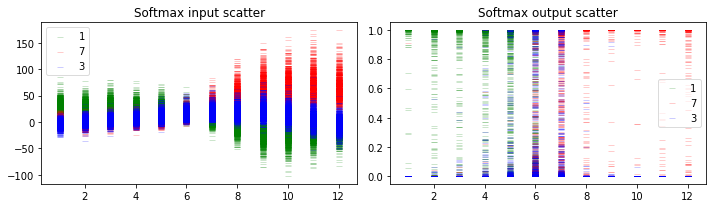

In [0]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 1].flatten(), \
            color='g', marker='_', linewidth=None, alpha=0.2, label='1');
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 7].flatten(), \
            color='r', marker='_', linewidth=None, alpha=0.2, label='7');
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 3].flatten(), \
            color='b', marker='_', linewidth=None, alpha=0.2, label='3');
plt.title('Softmax input scatter');
plt.legend(framealpha=0.7);

plt.subplot(1, 2, 2)
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 1].flatten(), \
            color='g', marker='_', linewidth=None, alpha=0.2, label='1');
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 7].flatten(), \
            color='r', marker='_', linewidth=None, alpha=0.2, label='7');
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 3].flatten(), \
            color='b', marker='_', linewidth=None, alpha=0.2, label='3');
plt.title('Softmax output scatter');
plt.legend(framealpha=0.7);

plt.tight_layout();


In [0]:
print('p(1 | vertical) = ', np.mean(y1_so[:, 0, 1]) )
print('var(1 | vertical) = ', np.sqrt(np.var(y1_so[:, 0, 1])) )

print('p(1 | diag) = ', np.mean(y1_so[:, 5, 1]) )
print('var(1 | diag) = ', np.sqrt(np.var(y1_so[:, 5, 1])) )

print('p(1 | horizontal) = ', np.mean(y1_so[:, 11, 1]) )
print('var(1 | horizontal) = ', np.sqrt(np.var(y1_so[:, 11, 1])) )

p(1 | vertical) =  0.99266094
var(1 | vertical) =  0.06765788
p(1 | diag) =  0.18636355
var(1 | diag) =  0.34405586
p(1 | horizontal) =  1.0040596e-09
var(1 | horizontal) =  2.4945335e-08
